In [1]:
from dataclasses import dataclass
from typing import List, Dict, Tuple
import os, json, re, unicodedata, hashlib
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from statistics import mean
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# --- konfiguracja ---
EMBEDDING_MODEL_NAME = "intfloat/multilingual-e5-large-instruct"
EMB_CACHE_PATH = "intent_embeddings.npz"
SIM_THRESHOLD = 0.42
MAYBE_THRESHOLD = 0.32
DEFAULT_INTENTS_JSON = "intents.json"
TESTSET_JSON = "testset.json" # Plik z danymi testowymi

# Symulacja modelu embedding: Wymagane sentence-transformers (w realnym środowisku)
_model = None

def get_model():
    """Ładuje model embeddingów SentenceTransformer lub zwraca jego mock (poprawiona składnia global)."""
    global _model # Deklaracja na początku funkcji
    if _model is None:
        from sentence_transformers import SentenceTransformer
        _model = SentenceTransformer(EMBEDDING_MODEL_NAME)

    return _model

# Funkcje przetwarzania tekstu i haszowania
def normalize_text(t: str) -> str:
    t = t.lower().strip()
    t = unicodedata.normalize("NFKD", t)
    t = re.sub(r"[^a-ząćęłńóśźż0-9\s]", " ", t)
    t = re.sub(r"\s+", " ", t)
    return t

def e5_encode(texts: List[str]) -> np.ndarray:
    model = get_model()
    return model.encode(texts, normalize_embeddings=True)

def embed_queries(texts: List[str]) -> np.ndarray:
    return e5_encode([f"query: {normalize_text(t)}" for t in texts])

def embed_passages(texts: List[str]) -> np.ndarray:
    return e5_encode([f"passage: {normalize_text(t)}" for t in texts])

def _file_sha1(path: str) -> str:
    """Oblicza SHA1 pliku. Jeśli plik nie istnieje, zwraca hasz nazwy."""
    h = hashlib.sha1()
    try:
        with open(path, "rb") as f:
            for chunk in iter(lambda: f.read(8192), b""):
                h.update(chunk)
        return h.hexdigest()
    except:
        return hashlib.sha1(path.encode()).hexdigest()

# Funkcje ładowania danych
def load_intents_from_json(path: str) -> Dict[str, Dict[str, List[str]]]:
    """Wczytuje intencje z pliku intents.json."""
    if not os.path.exists(path):
        # Symulowana zawartość w przypadku braku pliku (na podstawie Twojego kodu)
        print(f"Brak pliku {path}. Ładowanie z symulowanej zawartości (może się różnić od intencji treningowych).")
        intents_content = {
            "api/konie": {"examples": ["Proszę dodaj mi nowego konia Tajfuna"], "keywords": ["koń", "dodaj konia"]},
            "api/wydarzenia/zdarzenia_profilaktyczne": {"examples": ["Proszę dodać wpis, że moje konie miały odrobaczanie"], "keywords": ["profilaktyka", "szczepienie"]},
            "api/wydarzenia/rozrody": {"examples": ["Dino miał dzisiaj sprawdzanie źrebności."], "keywords": ["rozród", "ciąża"]},
            "api/wydarzenia/podkucie": {"examples": ["Dzisiaj Michał podkół mi wszystkie konie"], "keywords": ["podkucie", "kopyta"]},
            "api/wydarzenia/leczenia": {"examples": ["Dodaj leczenie kulawizny"], "keywords": ["leczenie", "terapia"]},
            "api/wydarzenia/choroby": {"examples": ["Ringo dzisiaj złamał nogę."], "keywords": ["choroba", "kolka"]},
            "api/kowale": {"examples": ["Dodaj mi kowala Jana Smarowskiego"], "keywords": ["kowal", "kowale"]},
            "api/weterynarze": {"examples": ["Dodaj mi weterynarza Jana Smarowskiego"], "keywords": ["weterynarz", "weterynarze"]}
        }
    else:
        with open(path, "r", encoding="utf-8") as f:
            intents_content = json.load(f)
            
    cleaned = {}
    for ep, spec in intents_content.items():
        if isinstance(spec, dict):
            exs = [x for x in spec.get("examples", []) if isinstance(x, str)]
            kws = [x for x in spec.get("keywords", []) if isinstance(x, str)]
            if exs:
                cleaned[ep] = {"examples": exs, "keywords": kws}
    if not cleaned:
        raise ValueError("Brak poprawnych intencji w pliku.")
    return cleaned


def load_testset_from_json(path: str):
    """Wczytuje testset z pliku testset.json."""
    if not os.path.exists(path):
        raise FileNotFoundError(f"Nie znaleziono pliku testowego: {path}. Sprawdź ścieżkę.")
        
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    if not isinstance(data, dict):
        raise ValueError("Plik testset JSON musi być słownikiem endpoint -> [lista tekstów].")
    testset_data = {norm_ep(ep): samples for ep, samples in data.items() if isinstance(samples, list) and all(isinstance(x, str) for x in samples)}

    if not testset_data:
        raise ValueError("Zbiór testowy jest pusty.")
    
    total_test_samples = sum(len(samples) for samples in testset_data.values())
    print(f"Załadowano testset z {total_test_samples} frazami.")
    return testset_data

def norm_ep(ep: str) -> str:
    """Ujednolica endpointy (usuwa początkowe /)."""
    ep = (ep or "").strip()
    if ep.startswith("/"):
        ep = ep[1:]
    return ep

In [16]:
@dataclass
class IntentIndex:
    # Wersja Centroid: embeddings = Centroidy intencji
    # Wersja k-NN: embeddings = Wszystkie przykłady
    endpoints: List[str] # Lista endpointów (unikalnych dla centroid, powtarzających się dla k-NN)
    embeddings: np.ndarray 
    texts: List[str] # Przykładowy tekst (Centroid) lub oryginalne frazy (k-NN)
    intents_hash: str
    is_knn_index: bool = False # Nowy parametr

# ----------------------------------------------------
# 2.1. Centroid (Wersja pierwotna)
# ----------------------------------------------------

def build_intent_index_centroid(intents: Dict[str, Dict[str, List[str]]], intents_hash: str) -> IntentIndex:
    """Tworzy indeks semantyczny poprzez uśrednianie embeddingów przykładów dla każdej intencji (Centroid)."""
    endpoints, endpoint_embs, texts = [], [], []
    for ep, spec in intents.items():
        exs = spec["examples"]
        emb = embed_passages(exs)
        # Obliczenie uśrednionego embeddingu dla intencji
        avg = np.mean(emb, axis=0) 
        endpoints.append(ep)
        endpoint_embs.append(avg)
        texts.append("; ".join(exs[:3]))
    return IntentIndex(endpoints, np.stack(endpoint_embs, axis=0), texts, intents_hash, is_knn_index=False)

def predict_endpoint_centroid(
    user_text: str,
    idx: IntentIndex,
    intents: Dict[str, Dict[str, List[str]]],
    sim_threshold: float = None,
    maybe_threshold: float = None,
    top_k: int = 5
) -> Dict:
    """Główna funkcja klasyfikatora (Centroid), łącząca semantykę i fallback."""
    q_emb = embed_queries([user_text])
    sims = cosine_similarity(q_emb, idx.embeddings)[0]

    # Obliczenie progów dynamicznych
    mean_s, std_s = float(np.mean(sims)), float(np.std(sims))
    if sim_threshold is None:
        sim_threshold = max(SIM_THRESHOLD, mean_s - 0.3 * std_s)
    if maybe_threshold is None:
        maybe_threshold = max(MAYBE_THRESHOLD, mean_s - 0.6 * std_s)

    # Reranking Top-K (użycie średniego score z top 5 najbliższych intencji)
    top_indices = np.argsort(sims)[-top_k:]
    ep_scores = {}
    for i in top_indices:
        ep = idx.endpoints[i]
        ep_scores.setdefault(ep, []).append(sims[i])
    
    best_ep = max(ep_scores, key=lambda e: np.mean(ep_scores[e]), default="")
    best_score = float(np.mean(ep_scores[best_ep])) if best_ep else 0.0

    # Logika klasyfikacji: Semantic > Semantic_Low (+Fallback) > Fallback > Unknown
    if best_score >= sim_threshold:
        return {"endpoint": best_ep, "score": round(best_score, 4), "method": "semantic"}

    if best_score >= maybe_threshold:
        ep_kw, reason = keyword_fallback(user_text, intents)
        if ep_kw:
            return {"endpoint": ep_kw, "score": round(best_score, 4), "method": "semantic+fallback", "debug": reason}
        return {"endpoint": best_ep, "score": round(best_score, 4), "method": "semantic_low"}

    ep_kw, reason = keyword_fallback(user_text, intents)
    if ep_kw:
        return {"endpoint": ep_kw, "score": round(best_score, 4), "method": "fallback", "debug": reason}

    return {"endpoint": "", "score": round(best_score, 4), "method": "unknown"}


# ----------------------------------------------------
# 2.2. k-NN (Nowa wersja)
# ----------------------------------------------------

def build_intent_index_knn(intents: Dict[str, Dict[str, List[str]]], intents_hash: str) -> IntentIndex:
    """Tworzy indeks k-NN, przechowując embeddingi wszystkich przykładów treningowych."""
    endpoints_all, embeddings_all, texts_all = [], [], []
    for ep, spec in intents.items():
        exs = spec["examples"]
        emb = embed_passages(exs)
        
        embeddings_all.append(emb)
        endpoints_all.extend([ep] * len(exs))
        texts_all.extend(exs)

    embeddings_combined = np.concatenate(embeddings_all, axis=0) if embeddings_all else np.array([])

    return IntentIndex(endpoints_all, embeddings_combined, texts_all, intents_hash, is_knn_index=True)


def predict_endpoint_knn(
    user_text: str,
    idx: IntentIndex,
    intents: Dict[str, Dict[str, List[str]]],
    k: int = 5, # Parametr K
    sim_threshold: float = None,
    maybe_threshold: float = None,
) -> Dict:
    """Funkcja klasyfikatora oparta na k-NN (większościowe głosowanie K najbliższych sąsiadów)."""
    if not idx.embeddings.size:
        return {"endpoint": "", "score": 0.0, "method": "unknown", "debug": "Pusty indeks k-NN"}

    q_emb = embed_queries([user_text])
    sims = cosine_similarity(q_emb, idx.embeddings)[0]
    
    # Znajdowanie K najbliższych sąsiadów (k+1, bo k=5 to 5 najbliższych, k=1 to 1)
    # Wybieramy 'k' największych wartości podobieństwa
    top_k_indices = np.argsort(sims)[-k:][::-1]
    
    top_k_endpoints = [idx.endpoints[i] for i in top_k_indices]
    top_k_scores = [sims[i] for i in top_k_indices]
    
    # Głosowanie: Wybór najczęściej występującego endpointa
    from collections import Counter
    vote_counts = Counter(top_k_endpoints)
    best_ep = vote_counts.most_common(1)[0][0] if vote_counts else ""
    
    # Wynik (score): Używamy średniej podobieństwa dla K najbliższych sąsiadów
    best_score = float(np.mean(top_k_scores)) if top_k_scores else 0.0

    # Obliczenie progów dynamicznych
    mean_s, std_s = float(np.mean(sims)), float(np.std(sims))
    if sim_threshold is None:
        sim_threshold = max(SIM_THRESHOLD, mean_s - 0.3 * std_s)
    if maybe_threshold is None:
        maybe_threshold = max(MAYBE_THRESHOLD, mean_s - 0.6 * std_s)

    # Logika klasyfikacji
    if best_score >= sim_threshold:
        return {"endpoint": best_ep, "score": round(best_score, 4), "method": f"knn_semantic (k={k})"}

    if best_score >= maybe_threshold:
        ep_kw, reason = keyword_fallback(user_text, intents)
        if ep_kw:
            return {"endpoint": ep_kw, "score": round(best_score, 4), "method": f"knn_semantic+fallback (k={k})", "debug": reason}
        return {"endpoint": best_ep, "score": round(best_score, 4), "method": f"knn_semantic_low (k={k})"}

    ep_kw, reason = keyword_fallback(user_text, intents)
    if ep_kw:
        return {"endpoint": ep_kw, "score": round(best_score, 4), "method": "fallback", "debug": reason}

    return {"endpoint": "", "score": round(best_score, 4), "method": "unknown"}

# Funkcja Fallback pozostaje ta sama
def keyword_fallback(text: str, intents: Dict[str, Dict[str, List[str]]]) -> Tuple[str, str]:
    """Prosty, stabilny fallback oparty o liczbę słów-kluczy."""
    t = normalize_text(text)
    best_ep, best_hits = "", 0
    for ep, spec in intents.items():
        hits = sum(1 for kw in spec.get("keywords", []) if normalize_text(kw) in t)
        if hits > best_hits:
            best_ep, best_hits = ep, hits
    return (best_ep, f"{best_hits} keyword hits") if best_hits else ("", "")

# Funkcja budowania/ładowania indeksu musi obsługiwać oba typy
def build_or_load_index(intents: Dict[str, Dict[str, List[str]]], intents_hash: str, model_type: str, force_rebuild: bool = False) -> IntentIndex:
    """Ładuje indeks z cache lub go buduje dla wybranego modelu."""
    # Tworzenie unikalnej ścieżki cache dla każdego typu modelu
    cache_path = EMB_CACHE_PATH.replace(".npz", f"_{model_type}.npz")
    
    if (not force_rebuild) and os.path.exists(cache_path):
        try:
            idx = load_index(cache_path)
            if idx.intents_hash == intents_hash:
                print(f"Załadowano indeks '{model_type}' z pamięci podręcznej (cache).")
                return idx
        except Exception:
            pass 
    
    print(f"Budowanie indeksu semantycznego ({model_type})...")
    if model_type == 'centroid':
        idx = build_intent_index_centroid(intents, intents_hash)
    elif model_type == 'knn':
        idx = build_intent_index_knn(intents, intents_hash)
    else:
        raise ValueError(f"Nieznany typ modelu: {model_type}")
        
    save_index(idx, cache_path)
    print("Indeks zbudowany i zapisany.")
    return idx

# Logika Predykcji
def keyword_fallback(text: str, intents: Dict[str, Dict[str, List[str]]]) -> Tuple[str, str]:
    """Prosty, stabilny fallback oparty o liczbę słów-kluczy."""
    t = normalize_text(text)
    best_ep, best_hits = "", 0
    for ep, spec in intents.items():
        hits = sum(1 for kw in spec.get("keywords", []) if normalize_text(kw) in t)
        if hits > best_hits:
            best_ep, best_hits = ep, hits
    return (best_ep, f"{best_hits} keyword hits") if best_hits else ("", "")

def predict_endpoint(
    user_text: str,
    idx: IntentIndex,
    intents: Dict[str, Dict[str, List[str]]],
    sim_threshold: float = None,
    maybe_threshold: float = None,
    top_k: int = 5
) -> Dict:
    """Główna funkcja klasyfikatora, łącząca semantykę i fallback."""
    q_emb = embed_queries([user_text])
    sims = cosine_similarity(q_emb, idx.embeddings)[0]

    # Obliczenie progów dynamicznych (adaptacyjne progi)
    mean_s, std_s = float(np.mean(sims)), float(np.std(sims))
    if sim_threshold is None:
        sim_threshold = max(SIM_THRESHOLD, mean_s - 0.3 * std_s)
    if maybe_threshold is None:
        maybe_threshold = max(MAYBE_THRESHOLD, mean_s - 0.6 * std_s)

    # Reranking Top-K dla stabilniejszego wyboru
    top_indices = np.argsort(sims)[-top_k:]
    ep_scores = {}
    for i in top_indices:
        ep = idx.endpoints[i]
        ep_scores.setdefault(ep, []).append(sims[i])
    
    best_ep = max(ep_scores, key=lambda e: np.mean(ep_scores[e]), default="")
    best_score = float(np.mean(ep_scores[best_ep])) if best_ep else 0.0

    # Logika klasyfikacji: Semantic > Semantic_Low (+Fallback) > Fallback > Unknown
    if best_score >= sim_threshold:
        return {"endpoint": best_ep, "score": round(best_score, 4), "method": "semantic"}

    if best_score >= maybe_threshold:
        ep_kw, reason = keyword_fallback(user_text, intents)
        if ep_kw:
            return {"endpoint": ep_kw, "score": round(best_score, 4), "method": "semantic+fallback", "debug": reason}
        return {"endpoint": best_ep, "score": round(best_score, 4), "method": "semantic_low"}

    ep_kw, reason = keyword_fallback(user_text, intents)
    if ep_kw:
        return {"endpoint": ep_kw, "score": round(best_score, 4), "method": "fallback", "debug": reason}

    return {"endpoint": "", "score": round(best_score, 4), "method": "unknown"}

In [19]:
def evaluate_classifier(intents: Dict, testset: Dict, intents_hash: str, model_type: str = 'centroid', knn_k: int = 5, force_rebuild: bool = False):
    """
    Uruchamia predykcję na całym zbiorze testowym, oblicza metryki i zwraca wyniki dla danego typu modelu.
    """
    idx = build_or_load_index(intents=intents, intents_hash=intents_hash, model_type=model_type, force_rebuild=force_rebuild)
    
    y_true, y_pred, samples_debug = [], [], []
    labels_for_report = sorted(set(list(testset.keys()) + list(intents.keys())))

    # Wybór funkcji predykcyjnej
    if model_type == 'centroid':
        predict_func = predict_endpoint_centroid
        method_name = "Centroid"
    elif model_type == 'knn':
        predict_func = lambda txt, i, ins: predict_endpoint_knn(txt, i, ins, k=knn_k)
        method_name = f"k-NN (k={knn_k})"
    else:
        raise ValueError("Nieznany typ modelu do ewaluacji.")

    # Główna pętla predykcyjna na testsecie
    for true_ep, texts in testset.items():
        for txt in texts:
            out = predict_func(txt, idx, intents)
            pred_ep = norm_ep(out.get("endpoint", ""))

            y_true.append(true_ep)
            y_pred.append(pred_ep)
            samples_debug.append({
                "text": txt,
                "true": true_ep,
                "pred": pred_ep,
                "method": out.get("method"),
                "score": out.get("score"),
                "debug": out.get("debug"),
            })

    # Obliczanie metryk (kod pozostaje taki sam)
    acc = accuracy_score(y_true, y_pred)
    pr_micro, rc_micro, f1_micro, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=labels_for_report, average="micro", zero_division=0
    )
    pr_macro, rc_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=labels_for_report, average="macro", zero_division=0
    )

    print(f"\n--- WYNIKI OGÓLNE ({method_name}) ---")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision (micro): {pr_micro:.4f} | Recall (micro): {rc_micro:.4f} | F1 (micro): {f1_micro:.4f}")
    print(f"Precision (macro): {pr_macro:.4f} | Recall (macro): {rc_macro:.4f} | F1 (macro): {f1_macro:.4f}")
    print()

    # Reszta funkcji jest taka sama, zwróci słownik wyników.
    cm = confusion_matrix(y_true, y_pred, labels=labels_for_report)
    errors = [s for s in samples_debug if s["true"] != s["pred"]]
    correct = [s for s in samples_debug if s["true"] == s["pred"]]
    
    return {
        "acc": acc,
        "f1_macro": f1_macro,
        "cm": cm,
        "labels": labels_for_report,
        "errors": errors,
        "correct": correct,
    }

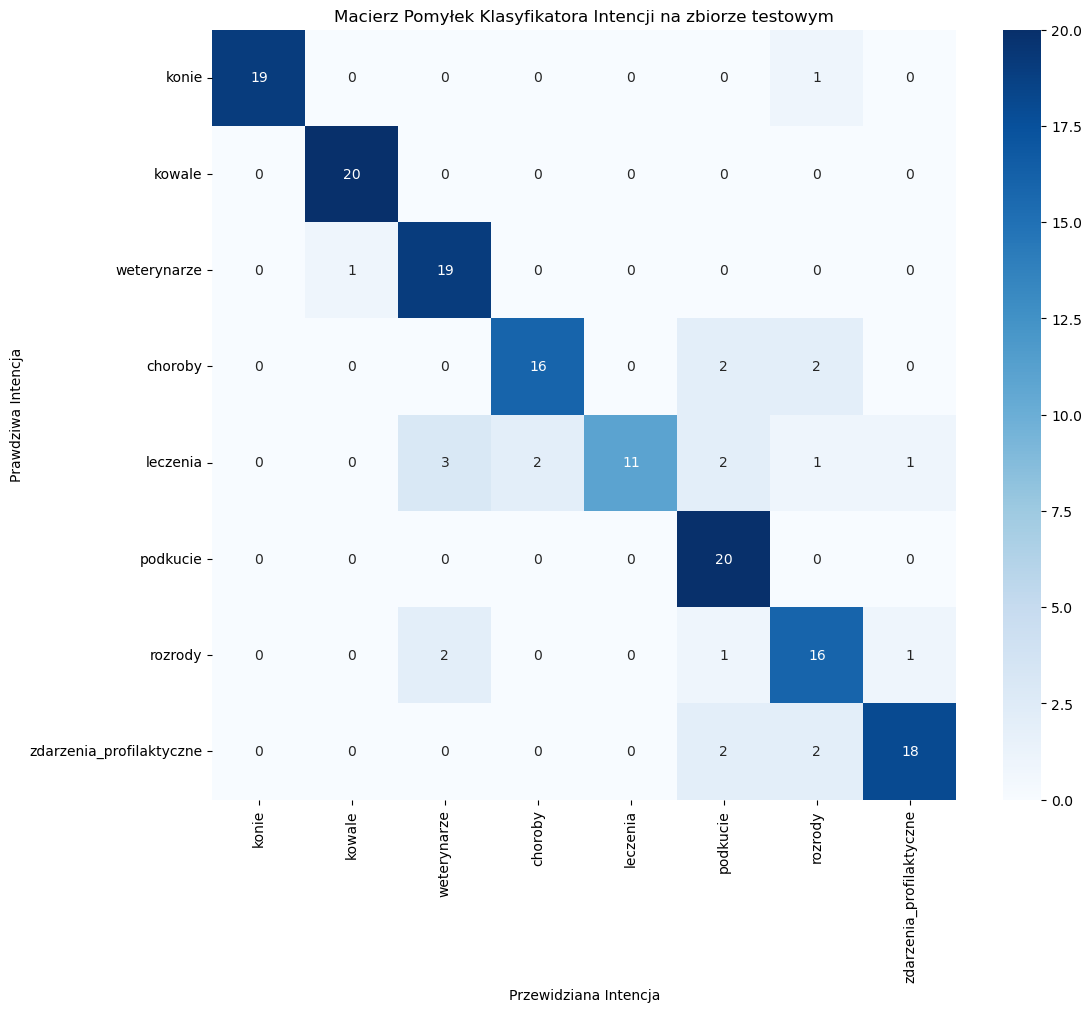

In [18]:
# Wizualizacja Macierzy Pomyłek
plt.figure(figsize=(12, 10))

# Użycie tylko ostatniej części endpointa dla lepszej czytelności etykiet
display_labels = [l.split('/')[-1] for l in labels]

sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="Blues", 
    xticklabels=display_labels, 
    yticklabels=display_labels,
    cbar=True
)
plt.title('Macierz Pomyłek Klasyfikatora Intencji na zbiorze testowym')
plt.ylabel('Prawdziwa Intencja')
plt.xlabel('Przewidziana Intencja')
plt.show()



In [20]:
errors = results["errors"]
correct = results["correct"]

if errors:
    print("\n=== STATYSTYKI SCORE ===")
    mean_correct = mean([s["score"] for s in correct if s["score"] is not None]) if correct else 0
    mean_wrong = mean([s["score"] for s in errors if s["score"] is not None]) if errors else 0
    print(f"Średni score poprawnych predykcji: {mean_correct:.4f}")
    print(f"Średni score błędnych predykcji:   {mean_wrong:.4f}")
    print(f"Łączna liczba błędnych predykcji: {len(errors)} / {total_test_samples}")
    print()

    print(f"=== PRZYKŁADOWE BŁĘDY (TOP-10 NAJNIŻSZYCH SCORE) ===")
    # Sortowanie błędów według najniższego score (najmniej pewne predykcje)
    errors.sort(key=lambda x: (x.get("score") if x.get("score") is not None else -1))
    for e in errors[:10]:
        print(f"- text: {e['text']}\n  true: {e['true']}\n  pred: {e['pred']} (method={e['method']}, score={e['score']}, debug={e.get('debug', 'N/A')})\n")
else:
    print("\nBrak błędnych predykcji ")


=== STATYSTYKI SCORE ===
Średni score poprawnych predykcji: 0.9291
Średni score błędnych predykcji:   0.9150
Łączna liczba błędnych predykcji: 23 / 162

=== PRZYKŁADOWE BŁĘDY (TOP-10 NAJNIŻSZYCH SCORE) ===
- text: Trzeba odrobaczyć Furię, wpisz to na za tydzień, zajmie się tym Tomasz Żuk.
  true: api/wydarzenia/zdarzenia_profilaktyczne
  pred: api/wydarzenia/podkucie (method=semantic, score=0.897, debug=None)

- text: Ringo wczoraj na treningu naciągnął sobie mięsień grzbietu.
  true: api/wydarzenia/choroby
  pred: api/wydarzenia/podkucie (method=semantic, score=0.8972, debug=None)

- text: Maks przyszedł i podał czarnej maść na ból stawów
  true: api/wydarzenia/leczenia
  pred: api/wydarzenia/podkucie (method=semantic, score=0.8976, debug=None)

- text: Dziś w nocy oźrebiła się Niwka! Poród odbierała Zofia Bukowska, wszystko w porządku.
  true: api/wydarzenia/rozrody
  pred: api/wydarzenia/podkucie (method=semantic, score=0.9032, debug=None)

- text: Bruno podał leki na pruchnice kró

In [21]:
# Ustawienie parametru K dla różnych scenariuszy
TEST_K_VALUES = [3, 5, 7]

print("=========================================")
print("  EWALUACJA KLASYFIKATORA: CENTROID vs k-NN")
print("=========================================")

# 1. Definicja scenariuszy testowych
test_scenarios = [
    {'type': 'centroid', 'k': 0, 'label': 'Centroid'},
]
for k in TEST_K_VALUES:
    test_scenarios.append({'type': 'knn', 'k': k, 'label': f'k-NN (k={k})'})

all_results = []

# 2. Wykonanie ewaluacji dla każdego scenariusza
for scenario in test_scenarios:
    model_type = scenario['type']
    knn_k = scenario['k']
    
    # Wymuszamy przebudowanie indeksu, jeśli typ modelu się zmienia
    # W Centroid i pierwszym k-NN, budujemy nowy indeks.
    force_rebuild = (model_type == 'centroid') or (model_type == 'knn' and knn_k == TEST_K_VALUES[0])
    
    print(f"\n--- Rozpoczęcie testu: {scenario['label']} ---")
    
    results = evaluate_classifier(
        intents=intents, 
        testset=testset, 
        intents_hash=intents_hash, 
        model_type=model_type,
        knn_k=knn_k,
        force_rebuild=force_rebuild
    )
    
    # Dodanie etykiety scenariusza i wyników do listy
    results['method_label'] = scenario['label']
    all_results.append(results)

# 3. Wyświetlenie tabeli podsumowującej
print("\n=========================================")
print(" PODSUMOWANIE WYNIKÓW EWALUACJI")
print("=========================================")
print("| Metoda      | Accuracy | F1-Macro |")
print("|-------------|----------|----------|")
for r in all_results:
    print(f"| {r['method_label']:<11} | {r['acc']:.4f}   | {r['f1_macro']:.4f}   |")
print("|-------------|----------|----------|")

  EWALUACJA KLASYFIKATORA: CENTROID vs k-NN

--- Rozpoczęcie testu: Centroid ---
Budowanie indeksu semantycznego (centroid)...
Indeks zbudowany i zapisany.

--- WYNIKI OGÓLNE (Centroid) ---
Accuracy: 0.8580
Precision (micro): 0.8580 | Recall (micro): 0.8580 | F1 (micro): 0.8580
Precision (macro): 0.8751 | Recall (macro): 0.8585 | F1 (macro): 0.8544


--- Rozpoczęcie testu: k-NN (k=3) ---
Budowanie indeksu semantycznego (knn)...
Indeks zbudowany i zapisany.

--- WYNIKI OGÓLNE (k-NN (k=3)) ---
Accuracy: 0.8580
Precision (micro): 0.8580 | Recall (micro): 0.8580 | F1 (micro): 0.8580
Precision (macro): 0.8608 | Recall (macro): 0.8591 | F1 (macro): 0.8543


--- Rozpoczęcie testu: k-NN (k=5) ---
Załadowano indeks 'knn' z pamięci podręcznej (cache).

--- WYNIKI OGÓLNE (k-NN (k=5)) ---
Accuracy: 0.8765
Precision (micro): 0.8765 | Recall (micro): 0.8765 | F1 (micro): 0.8765
Precision (macro): 0.8836 | Recall (macro): 0.8756 | F1 (macro): 0.8717


--- Rozpoczęcie testu: k-NN (k=7) ---
Załadowano 

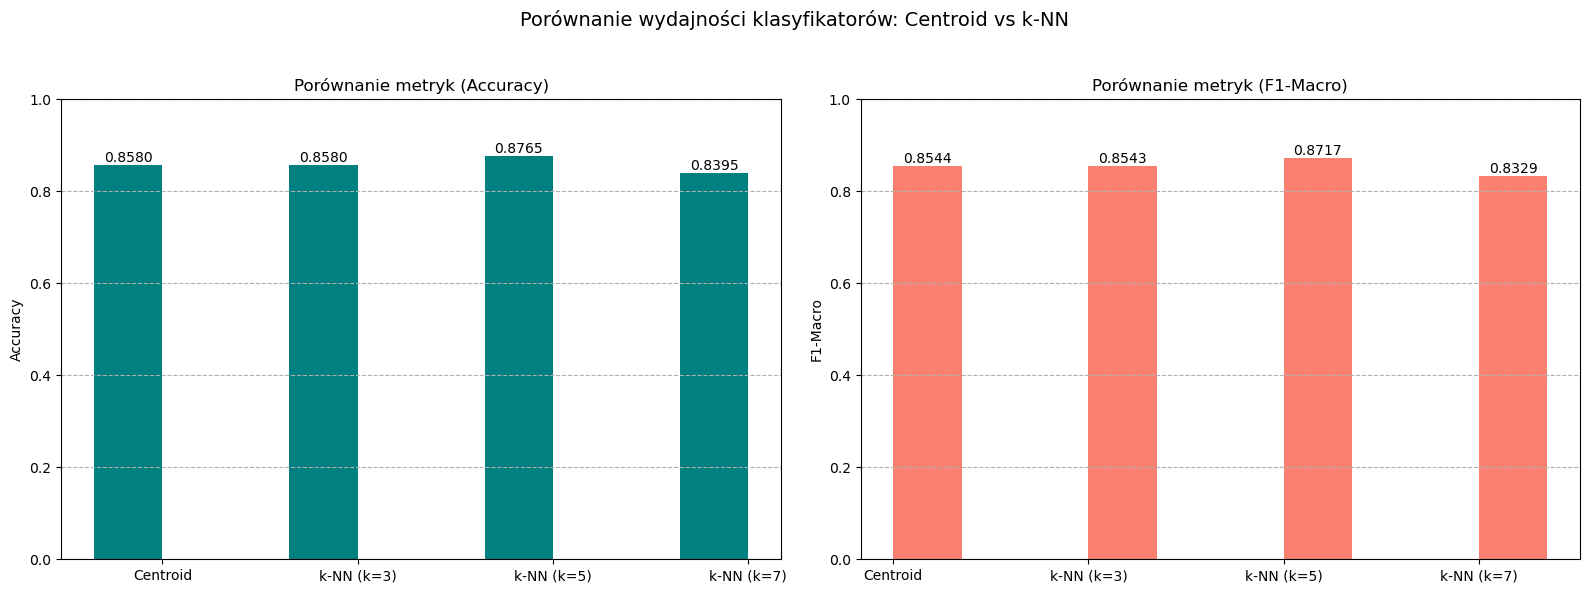


🖼️ WIZUALIZACJA: MACIERZ POMYŁEK DLA k-NN (k=5)


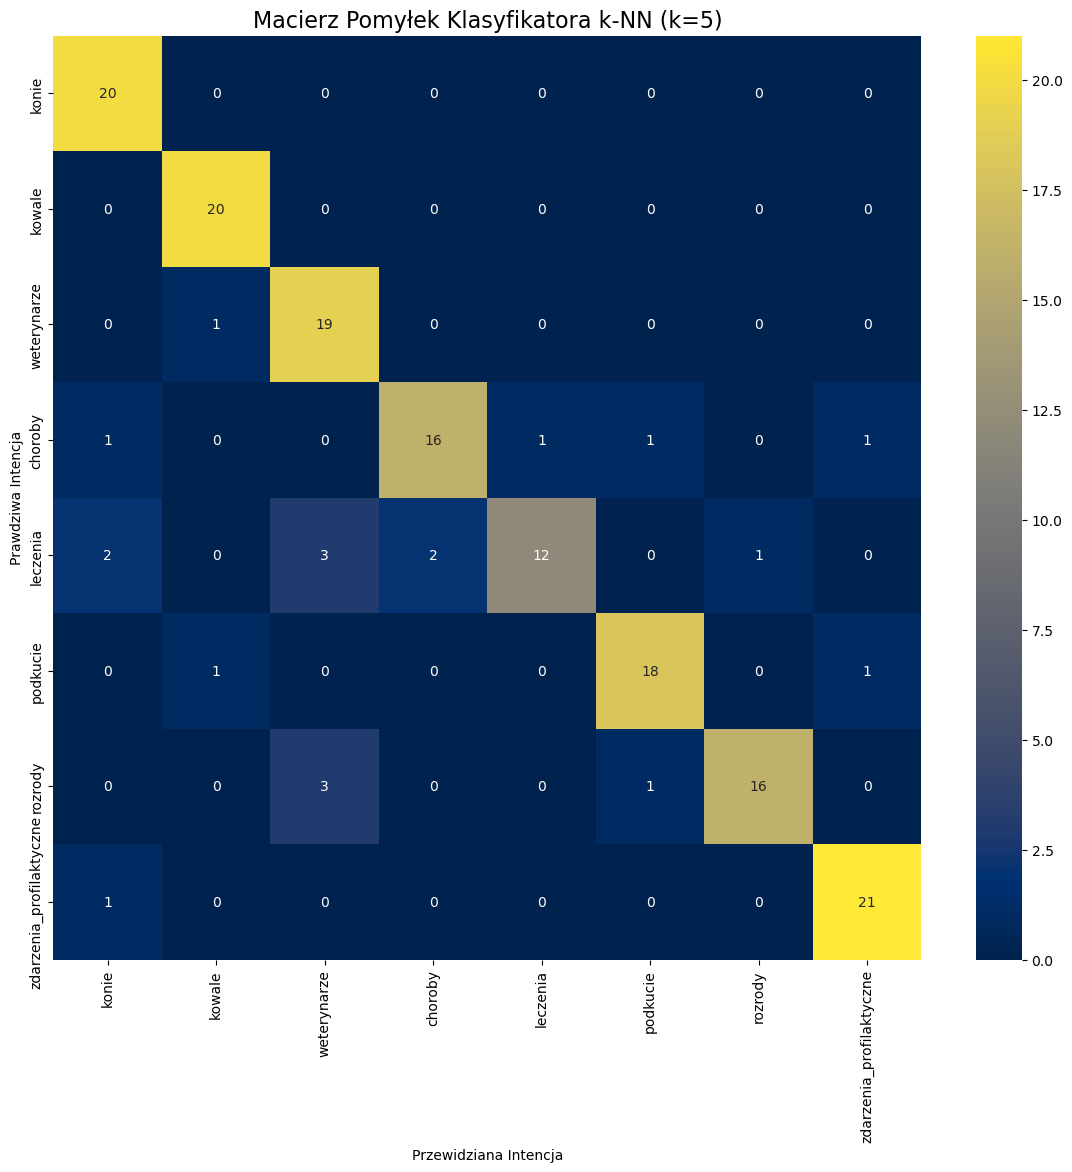

In [23]:
# Dane do wizualizacji (pobrane ze zmiennej all_results z poprzedniego bloku)
df_results = {
    'Metoda': [r['method_label'] for r in all_results],
    'Accuracy': [r['acc'] for r in all_results],
    'F1-Macro': [r['f1_macro'] for r in all_results],
}

# 1. Wizualizacja Porównawcza (Accuracy i F1-Macro)
plt.figure(figsize=(16, 6))
x = np.arange(len(df_results['Metoda']))
width = 0.35
labels = df_results['Metoda']

# --- Wykres Accuracy ---
plt.subplot(1, 2, 1)
rects1 = plt.bar(x - width/2, df_results['Accuracy'], width, label='Accuracy', color='teal')
plt.ylabel('Accuracy')
plt.title('Porównanie metryk (Accuracy)')
plt.xticks(x, labels)
plt.bar_label(rects1, fmt='%.4f')
plt.ylim(0.0, 1.0)
plt.grid(axis='y', linestyle='--')

# --- Wykres F1-Macro ---
plt.subplot(1, 2, 2)
rects2 = plt.bar(x + width/2, df_results['F1-Macro'], width, label='F1-Macro', color='salmon')
plt.ylabel('F1-Macro')
plt.title('Porównanie metryk (F1-Macro)')
plt.xticks(x, labels)
plt.bar_label(rects2, fmt='%.4f')
plt.ylim(0.0, 1.0)
plt.grid(axis='y', linestyle='--')

plt.suptitle('Porównanie wydajności klasyfikatorów: Centroid vs k-NN', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show() # Wyświetlenie wykresów

# 2. Wybór i Wizualizacja Macierzy Pomyłek (CM)
# Wybieramy Macierz Pomyłek dla k-NN (k=5) do szczegółowej analizy
CM_SCENARIO_INDEX = 2 # Indeks 2 odpowiada 'k-NN (k=5)' (0=Centroid, 1=k-NN k=3, 2=k-NN k=5)
selected_results = all_results[CM_SCENARIO_INDEX]

cm = selected_results["cm"]
labels_full = selected_results["labels"]
cm_method = selected_results["method_label"]
display_labels = [l.split('/')[-1] for l in labels_full] # Skrócone nazwy endpointów

print(f"\n=========================================")
print(f"🖼️ WIZUALIZACJA: MACIERZ POMYŁEK DLA {cm_method}")
print("=========================================")

plt.figure(figsize=(14, 12))
sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="cividis", # Ciemniejszy, kontrastowy schemat
    xticklabels=display_labels, 
    yticklabels=display_labels,
    cbar=True
)
plt.title(f'Macierz Pomyłek Klasyfikatora {cm_method}', fontsize=16)
plt.ylabel('Prawdziwa Intencja')
plt.xlabel('Przewidziana Intencja')
plt.show() # Wyświetlenie macierzy pomyłek



In [ ]:
import json
import os
import argparse
import numpy as np
from typing import Dict, List, Tuple
from dataclasses import dataclass

# Import classifiers as modules
import classifier1
import classifier3

# --- Configuration ---
DEFAULT_INTENTS_JSON = "intents.json"

@dataclass
class VotingResources:
    idx1: classifier1.IntentIndex
    idx3: classifier3.IntentIndex
    intents: Dict[str, Dict[str, List[str]]]

def load_resources(intents_path: str = DEFAULT_INTENTS_JSON) -> VotingResources:
    """Loads resources for both classifiers."""
    intents = classifier1.load_intents_from_json(intents_path)
    intents_hash = classifier1._file_sha1(intents_path)
    
    # Load indexes
    # Note: They use different cache files (defined in their modules)
    print("Loading Index 1 (Centroid)...")
    idx1 = classifier1.build_or_load_index(intents, intents_hash)
    
    print("Loading Index 3 (Ensemble KNN)...")
    idx3 = classifier3.build_or_load_index(intents, intents_hash)
    
    return VotingResources(idx1, idx3, intents)

def predict_voting(text: str, res: VotingResources) -> Dict:
    """
    Predicts endpoint using a voting mechanism between Classifier 1 and Classifier 3.
    """
    
    pred1 = classifier1.predict_endpoint(text, res.idx1, res.intents)
    pred3 = classifier3.predict_endpoint(text, res.idx3, res.intents)
    
    ep1 = pred1["endpoint"]
    score1 = pred1["score"]
    method1 = pred1["method"]
    
    ep3 = pred3["endpoint"]
    score3 = pred3["score"]
    method3 = pred3["method"]
    
    # --- Voting Logic ---
    
    # Priority to Classifier 3 (Ensemble KNN) because it has proven higher accuracy (0.89 vs lower for C1).
    # C1 tends to be overconfident.
    
    # Threshold for trusting C3 implicitly
    C3_TRUST_THRESHOLD = 0.85

    # Case 1: Agreement
    if ep1 == ep3 and ep1 != "":
        final_score = max(score1, score3)
        return {
            "endpoint": ep1,
            "score": final_score,
            "method": f"voting_agreement",
            "details": {"c1": pred1, "c3": pred3}
        }

    # Case 2: Disagreement
    # If C3 is confident enough, trust it.
    if score3 >= C3_TRUST_THRESHOLD:
        return {**pred3, "method": f"voting_trust_c3_high_score", "details": {"c1": pred1, "c3": pred3}}

    # If C3 is not confident, check if C1 is significantly better?
    # Or fallback to score comparison (risky if C1 is overconfident)
    
    # If scores are close, prefer C3
    if score3 >= score1 - 0.03: # Handicap: C3 wins even if slightly lower
         return {**pred3, "method": f"voting_prefer_c3", "details": {"c1": pred1, "c3": pred3}}

    # If C1 is MUCH more confident than C3, trust C1
    if score1 > score3:
         return {**pred1, "method": f"voting_c1_override_low_c3", "details": {"c1": pred1, "c3": pred3}}
    
    # Default to C3
    return {**pred3, "method": f"voting_default_c3", "details": {"c1": pred1, "c3": pred3}}


try:
    res = load_resources(DEFAULT_INTENTS_JSON)
    print("Resources loaded successfully!")
except Exception as e:
    print(f"Error loading resources: {e}")

# --- Funkcja do testowania w notebooku ---
def test_predict(text: str):
    result = predict_voting(text, res)
    print(f"Input: {text}")
    print(json.dumps(result, ensure_ascii=False, indent=2))

# Przykład użycia bezpośrednio w komórce:
# test_predict("Weterynarz Marka podała koniu Mewie 2 tabletki leku przeciwbólowego.")

Loading Index 1 (Centroid)...
Loading Index 3 (Ensemble KNN)...
Resources loaded successfully!


c:\Users\dell\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Input: Weterynarz Marka podała koniu Mewie 2 tabletki leku przeciwbólowego.


TypeError: Object of type float32 is not JSON serializable

In [7]:
import argparse, json, os, numpy as np
from statistics import mean
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import classifier_voting
# Reuse utility functions from classifier3 (or similar)
from classifier3 import _file_sha1, DEFAULT_INTENTS_JSON



def norm_ep(ep: str) -> str:
    """Ujednolica endpointy (usuwa początkowe /)."""
    ep = (ep or "").strip()
    if ep.startswith("/"):
        ep = ep[1:]
    return ep

def load_testset(path: str):
    """Wczytuje testset JSON (endpoint -> [frazy])."""
    if not os.path.exists(path):
        raise FileNotFoundError(f"Nie znaleziono pliku: {path}")
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    if not isinstance(data, dict):
        raise ValueError("Plik testset JSON musi być słownikiem endpoint -> [lista tekstów].")
    norm_data = {}
    for ep, samples in data.items():
        nep = norm_ep(ep)
        if not isinstance(samples, list) or not all(isinstance(x, str) for x in samples):
            raise ValueError(f"Wartość dla '{ep}' musi być listą stringów.")
        norm_data[nep] = samples
    if not norm_data:
        raise ValueError("Zbiór testowy jest pusty.")
    return norm_data

def evaluate(intents_path: str, testset_path: str):
    # Load resources for voting classifier
    print("Loading Voting Classifier resources...")
    res = classifier_voting.load_resources(intents_path)
    
    testset = load_testset(testset_path)

    y_true, y_pred, samples_debug = [], [], []
    # Make sure we cover all intent labels
    labels_for_report = sorted(set(list(testset.keys()) + list(res.intents.keys())))

    print(f"Uruchamianie ewaluacji VOTING CLASSIFIER (C1 + C3)")

    for true_ep, texts in testset.items():
        for txt in texts:
            out = classifier_voting.predict_voting(txt, res)
            pred_ep = norm_ep(out.get("endpoint", ""))

            y_true.append(true_ep)
            y_pred.append(pred_ep)
            samples_debug.append({
                "text": txt,
                "true": true_ep,
                "pred": pred_ep,
                "method": out.get("method"),
                "score": out.get("score"),
                "details": out.get("details"), # Extra details for debugging
            })

    acc = accuracy_score(y_true, y_pred)
    pr_micro, rc_micro, f1_micro, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=labels_for_report, average="micro", zero_division=0
    )
    pr_macro, rc_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=labels_for_report, average="macro", zero_division=0
    )

    print("=== WYNIKI OGÓLNE ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision (micro): {pr_micro:.4f} | Recall (micro): {rc_micro:.4f} | F1 (micro): {f1_micro:.4f}")
    print(f"Precision (macro): {pr_macro:.4f} | Recall (macro): {rc_macro:.4f} | F1 (macro): {f1_macro:.4f}")
    print()

    print("=== RAPORT PER-ENDPOINT ===")
    print(classification_report(y_true, y_pred, labels=labels_for_report, zero_division=0, digits=4))
    print()

    print("=== MACIERZ POMYŁEK ===")
    cm = confusion_matrix(y_true, y_pred, labels=labels_for_report)
    header = ["true\\pred"] + labels_for_report
    row_fmt = "{:>28} " + " ".join(["{:>28}"] * len(labels_for_report))
    print(row_fmt.format(*header))
    for i, row in enumerate(cm):
        print(row_fmt.format(labels_for_report[i], *row))
    print()

    errors = [s for s in samples_debug if s["true"] != s["pred"]]
    correct = [s for s in samples_debug if s["true"] == s["pred"]]
    if errors:
        print("=== STATYSTYKI SCORE ===")
        mean_correct = mean([float(s["score"]) for s in correct if s["score"] is not None]) if correct else 0
        mean_wrong = mean([float(s["score"]) for s in errors if s["score"] is not None]) if errors else 0
        print(f"Średni score poprawnych: {mean_correct:.4f}")
        print(f"Średni score błędnych:   {mean_wrong:.4f}")
        print()

        print("=== PRZYKŁADOWE BŁĘDY (TOP-10 NAJNIŻSZYCH SCORE) ===")
        errors.sort(key=lambda x: (x.get("score") if x.get("score") is not None else -1))
        for e in errors[:10]:
            print(f"- text: {e['text']}\n  true: {e['true']}\n  pred: {e['pred']} (method={e['method']}, score={e['score']})\n")
    else:
        print("Brak błędnych predykcji 🎉")

# --- KONFIGURACJA I URUCHOMIENIE ---
INTENTS_FILE = "intents2.json" 
TESTSET_FILE = "testset.json"

if __name__ == "__main__":
    if os.path.exists(TESTSET_FILE):
        evaluate(INTENTS_FILE, TESTSET_FILE)
    else:
        print(f"BŁĄD: Nie znaleziono pliku testowego: {TESTSET_FILE}")


Loading Voting Classifier resources...
Loading Index 1 (Centroid)...

Loading Index 3 (Ensemble KNN)...
Uruchamianie ewaluacji VOTING CLASSIFIER (C1 + C3)
=== WYNIKI OGÓLNE ===
Accuracy: 0.9074
Precision (micro): 0.9074 | Recall (micro): 0.9074 | F1 (micro): 0.9074
Precision (macro): 0.9094 | Recall (macro): 0.9068 | F1 (macro): 0.9022

=== RAPORT PER-ENDPOINT ===
                                         precision    recall  f1-score   support

                              api/konie     0.9524    1.0000    0.9756        20
                             api/kowale     0.9091    1.0000    0.9524        20
                        api/weterynarze     0.8261    0.9500    0.8837        20
                 api/wydarzenia/choroby     0.9000    0.9000    0.9000        20
                api/wydarzenia/leczenia     0.9231    0.6000    0.7273        20
                api/wydarzenia/podkucie     0.8696    1.0000    0.9302        20
                 api/wydarzenia/rozrody     0.8947    0.8500    0

Loading Index 1 (Centroid)...
Loading Index 3 (Ensemble KNN)...
Testowanie: Centroid...
Testowanie: k-NN...
Testowanie: VOTING...


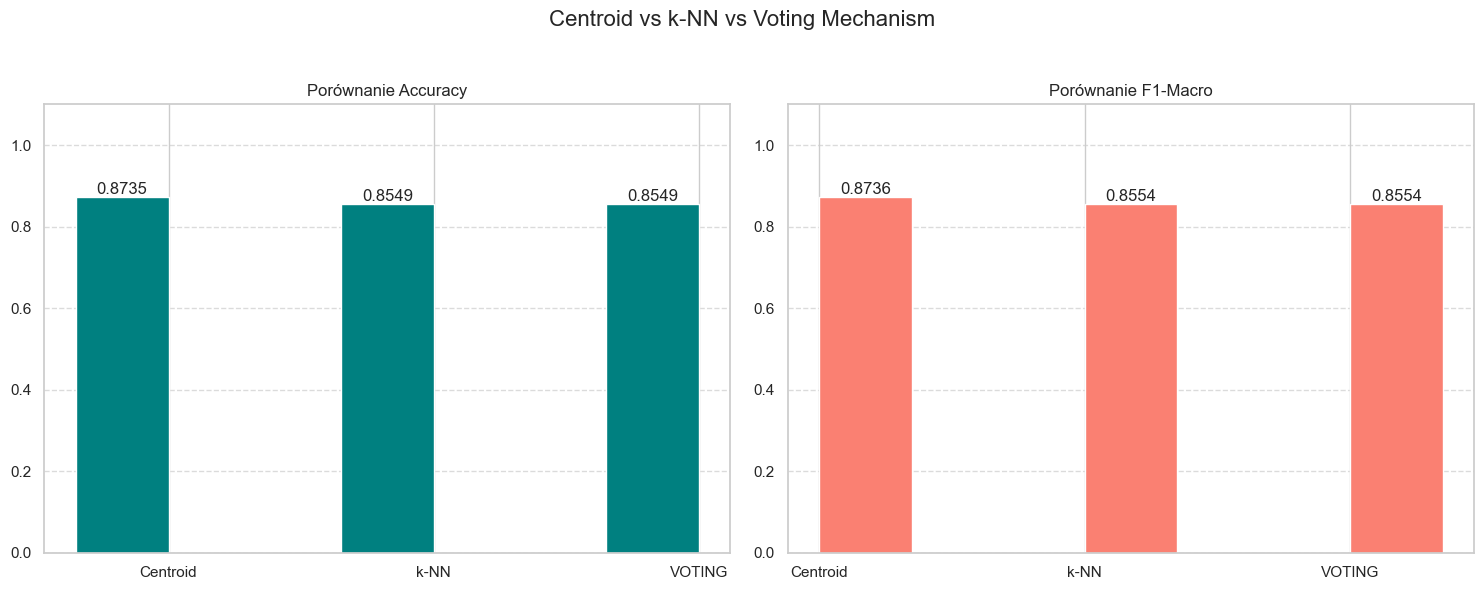

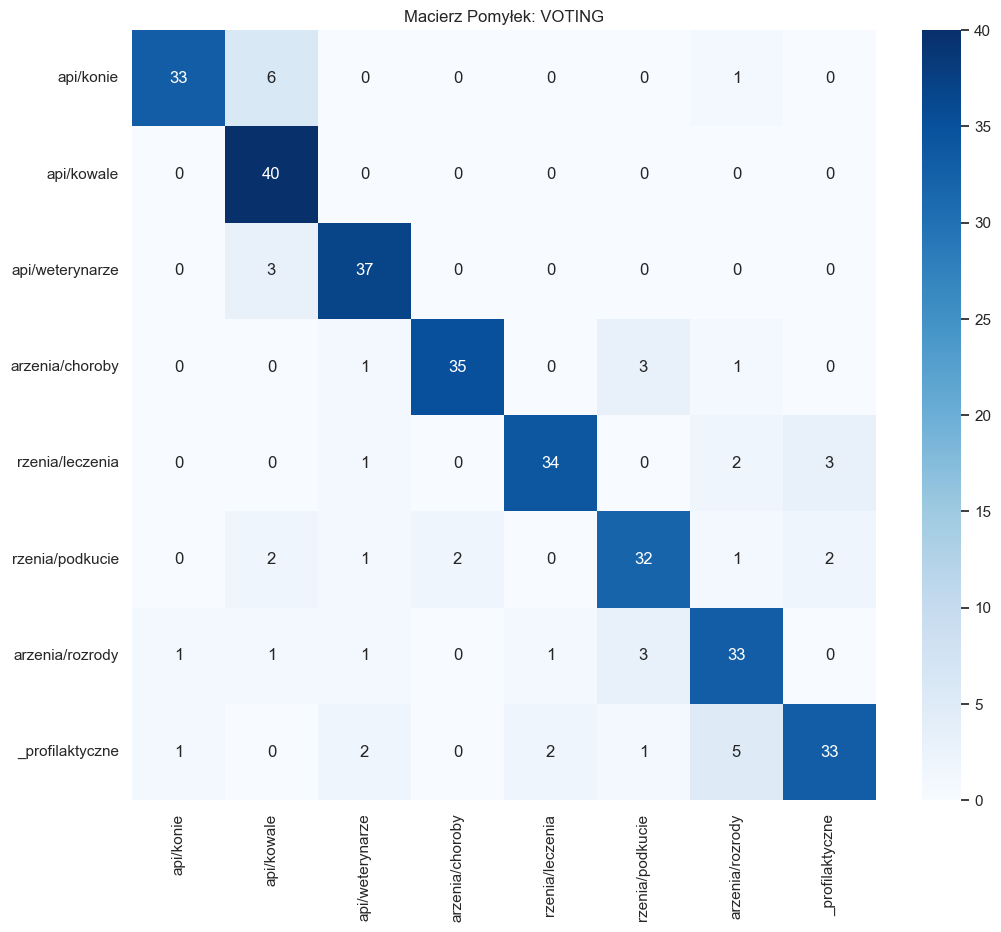

In [15]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple
from dataclasses import dataclass
from statistics import mean
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

# Importy Twoich modułów
import classifier1
import classifier3

# --- 1. Definicje Klas i Logiki Głosowania ---

@dataclass
class VotingResources:
    idx1: classifier1.IntentIndex
    idx3: classifier3.IntentIndex
    intents: Dict[str, Dict[str, List[str]]]

def load_voting_resources(intents_path: str) -> VotingResources:
    intents = classifier1.load_intents_from_json(intents_path)
    intents_hash = classifier1._file_sha1(intents_path)
    print("Loading Index 1 (Centroid)...")
    idx1 = classifier1.build_or_load_index(intents, intents_hash)
    print("Loading Index 3 (Ensemble KNN)...")
    idx3 = classifier3.build_or_load_index(intents, intents_hash)
    return VotingResources(idx1, idx3, intents)

def predict_voting(text: str, res: VotingResources) -> Dict:
    pred1 = classifier1.predict_endpoint(text, res.idx1, res.intents)
    pred3 = classifier3.predict_endpoint(text, res.idx3, res.intents)
    ep1, score1 = pred1["endpoint"], pred1["score"]
    ep3, score3 = pred3["endpoint"], pred3["score"]
    
    C3_TRUST_THRESHOLD = 0.85
    if ep1 == ep3 and ep1 != "":
        return {"endpoint": ep1, "score": max(score1, score3), "method": "voting_agreement"}
    if score3 >= C3_TRUST_THRESHOLD:
        return {**pred3, "method": "voting_trust_c3_high_score"}
    if score3 >= score1 - 0.03:
         return {**pred3, "method": "voting_prefer_c3"}
    if score1 > score3:
         return {**pred1, "method": "voting_c1_override_low_c3"}
    return {**pred3, "method": "voting_default_c3"}

# --- 2. Narzędzia Ewaluacji ---

def norm_ep(ep: str) -> str:
    ep = (ep or "").strip()
    return ep[1:] if ep.startswith("/") else ep

def load_testset(path: str):
    if not os.path.exists(path): return None
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    return {norm_ep(ep): samples for ep, samples in data.items()}

# --- 3. Główna Funkcja Porównawcza ---

def run_comprehensive_evaluation(intents_path, testset_path):
    res = load_voting_resources(intents_path)
    testset = load_testset(testset_path)
    if not testset:
        print("Błąd: Nie znaleziono zbioru testowego.")
        return

    intents_hash = classifier1._file_sha1(intents_path)
    all_labels = sorted(set(list(testset.keys()) + list(res.intents.keys())))
    
    # Definicja scenariuszy do porównania
    scenarios = [
        {'label': 'Centroid', 'type': 'c1'},
        {'label': 'k-NN', 'type': 'c3'},
        {'label': 'VOTING', 'type': 'voting'}
    ]
    
    all_results = []

    for sc in scenarios:
        print(f"Testowanie: {sc['label']}...")
        y_true, y_pred = [], []
        
        for true_ep, texts in testset.items():
            for txt in texts:
                if sc['type'] == 'c1':
                    # Centroid (classifier1)
                    out = classifier1.predict_endpoint(txt, res.idx1, res.intents)
                elif sc['type'] == 'c3':
                    out = classifier3.predict_endpoint(
                        txt, 
                        res.idx3, 
                        res.intents
                    )
                else:
                    # Twój zintegrowany model Voting
                    out = predict_voting(txt, res)
                
                y_true.append(true_ep)
                y_pred.append(norm_ep(out.get("endpoint", "")))
        
        acc = accuracy_score(y_true, y_pred)
        _, _, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=all_labels, average='macro', zero_division=0)
        
        all_results.append({
            'label': sc['label'],
            'acc': acc,
            'f1': f1,
            'cm': confusion_matrix(y_true, y_pred, labels=all_labels)
        })

    # --- WIZUALIZACJA PORÓWNAWCZA ---
    labels = [r['label'] for r in all_results]
    acc_vals = [r['acc'] for r in all_results]
    f1_vals = [r['f1'] for r in all_results]
    
    x = np.arange(len(labels))
    width = 0.35

    plt.figure(figsize=(15, 6))
    
    # Wykres Accuracy
    plt.subplot(1, 2, 1)
    bar1 = plt.bar(x - width/2, acc_vals, width, label='Accuracy', color='teal')
    plt.xticks(x, labels)
    plt.title('Porównanie Accuracy')
    plt.ylim(0, 1.1)
    plt.bar_label(bar1, fmt='%.4f')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Wykres F1-Macro
    plt.subplot(1, 2, 2)
    bar2 = plt.bar(x + width/2, f1_vals, width, label='F1-Macro', color='salmon')
    plt.xticks(x, labels)
    plt.title('Porównanie F1-Macro')
    plt.ylim(0, 1.1)
    plt.bar_label(bar2, fmt='%.4f')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.suptitle('Centroid vs k-NN vs Voting Mechanism', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # --- MACIERZ POMYŁEK DLA VOTING (ostatni wynik) ---
    voting_res = all_results[-1]
    plt.figure(figsize=(12, 10))
    sns.heatmap(voting_res['cm'], annot=True, fmt="d", cmap="Blues",
                xticklabels=[l[-15:] for l in all_labels], 
                yticklabels=[l[-15:] for l in all_labels])
    plt.title(f"Macierz Pomyłek: {voting_res['label']}")
    plt.show()

# --- URUCHOMIENIE ---
INTENTS_FILE = "intents2.json"
TESTSET_FILE = "testset2.json"

run_comprehensive_evaluation(INTENTS_FILE, TESTSET_FILE)

C:\Users\HP\AppData\Local\Temp\ipykernel_11736\4199915272.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Wykres został pomyślnie zapisany jako: C:\Users\HP\Desktop\studia\Semestr7\Inżynierka\Inzynierka_klasyfikator\Inzynierka_klasyfikator\knn_evaluation_results.png


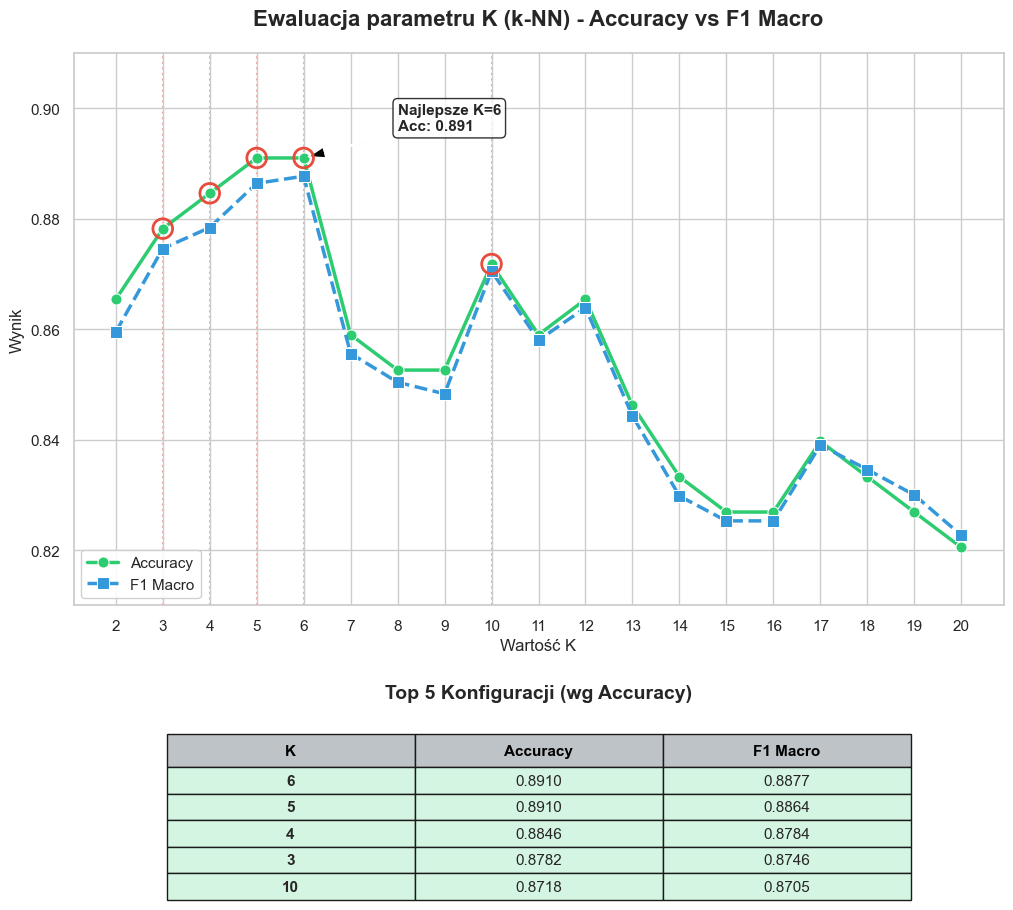

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os

# --- 1. Dane wejściowe ---
data = {
    'K': list(range(2, 21)),
    'Accuracy': [
        0.8654, 0.8782, 0.8846, 0.8910, 0.8910, 
        0.8590, 0.8526, 0.8526, 0.8718, 0.8590, 
        0.8654, 0.8462, 0.8333, 0.8269, 0.8269, 
        0.8397, 0.8333, 0.8269, 0.8205
    ],
    'F1 Macro': [
        0.8595, 0.8746, 0.8784, 0.8864, 0.8877, 
        0.8556, 0.8504, 0.8483, 0.8705, 0.8580, 
        0.8639, 0.8443, 0.8298, 0.8253, 0.8253, 
        0.8390, 0.8346, 0.8300, 0.8227
    ]
}

# Tworzymy DataFrame
df = pd.DataFrame(data)

# Wyróżnione wartości K (Ensemble)
ensemble_k = [3, 4, 5, 6, 10]

# --- 2. Konfiguracja stylu ---
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans']

# Tworzymy figurę i osie
fig = plt.figure(figsize=(12, 11)) # Troszkę wyższy, żeby tabela miała miejsce
gs = fig.add_gridspec(2, 1, height_ratios=[3, 1], hspace=0.3)

ax_plot = fig.add_subplot(gs[0])
ax_table = fig.add_subplot(gs[1])

# --- 3. Rysowanie wykresu ---
# Linie
sns.lineplot(data=df, x='K', y='Accuracy', ax=ax_plot, marker='o', label='Accuracy', 
             color='#2ecc71', linewidth=2.5, markersize=8)
sns.lineplot(data=df, x='K', y='F1 Macro', ax=ax_plot, marker='s', label='F1 Macro', 
             color='#3498db', linewidth=2.5, markersize=8, linestyle='--')

# Podświetlenie wybranych K (Ensemble)
for k in ensemble_k:
    # Pobieramy wartość dla danego K
    row = df[df['K'] == k].iloc[0]
    ax_plot.axvline(x=k, color='#e74c3c', linestyle=':', alpha=0.5, zorder=0)
    # Dodatkowe kółko wokół punktu
    ax_plot.scatter(k, row['Accuracy'], s=200, facecolors='none', edgecolors='#e74c3c', linewidth=2, zorder=10)

# Opisy i formatowanie wykresu
ax_plot.set_title('Ewaluacja parametru K (k-NN) - Accuracy vs F1 Macro', fontsize=16, pad=20, fontweight='bold')
ax_plot.set_xlabel('Wartość K', fontsize=12)
ax_plot.set_ylabel('Wynik', fontsize=12)
ax_plot.set_xticks(range(2, 21)) # Jawne ustawienie ticków dla każdego K
ax_plot.set_ylim(0.81, 0.91)
ax_plot.legend(loc='lower left', frameon=True, fontsize=11, framealpha=0.9)

# Dodanie adnotacji "Top Pick"
best_k = 6
best_acc = 0.8910
ax_plot.annotate(f'Najlepsze K={best_k}\nAcc: {best_acc}', 
                 xy=(best_k, best_acc), xytext=(best_k+2, best_acc+0.005),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
                 fontsize=11, fontweight='bold',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8))

# --- 4. Rysowanie tabeli (POPRAWIONE) ---
ax_table.axis('off')
ax_table.set_title("Top 5 Konfiguracji (wg Accuracy)", fontsize=14, fontweight='bold', y=1.05)

# Przygotowanie danych do tabeli (Top 5)
top_5 = df.sort_values(by=['Accuracy', 'F1 Macro'], ascending=False).head(5)
top_5_values = top_5.values.tolist()
col_labels = ['K', 'Accuracy', 'F1 Macro']

# !!! TU BYŁ BRAKUJĄCY ELEMENT: Tworzenie tabeli !!!
the_table = ax_table.table(
    cellText=[[int(x[0]), f"{x[1]:.4f}", f"{x[2]:.4f}"] for x in top_5_values],
    colLabels=col_labels,
    loc='center',
    cellLoc='center',
    colColours=['#ecf0f1']*3,
    bbox=[0.1, 0, 0.8, 0.9] # Wyśrodkowanie i skalowanie tabeli
)

the_table.auto_set_font_size(False)
the_table.set_fontsize(11)

# Stylizacja nagłówków i wierszy tabeli (ZABEZPIECZONA)
for (row, col), cell in the_table.get_celld().items():
    if row == 0:
        # Nagłówek
        cell.set_text_props(weight='bold', color='black')
        cell.set_facecolor('#bdc3c7')
        cell.set_height(0.15)
    elif row > 0:
        cell.set_height(0.12)
        
        # Logika podświetlania (bezpieczna wersja)
        # Pobieramy wartość K z kolumny 0 dla aktualnego wiersza
        try:
            # cell.get_text() zwraca obiekt Text, drugi get_text() zwraca string
            k_cell_obj = the_table[row, 0].get_text() 
            k_val_str = k_cell_obj.get_text()
            
            k_val = int(float(k_val_str))
            
            if k_val in ensemble_k:
                cell.set_facecolor('#d5f5e3') # Jasny zielony dla wyróżnionych
                if col == 0:
                     cell.set_text_props(weight='bold')
        except Exception as e:
            # W razie błędu przy rzutowaniu po prostu pomijamy stylowanie
            pass

# --- 5. Zapis i wyświetlenie ---
plt.tight_layout()
filename = 'knn_evaluation_results.png'
# bbox_inches='tight' jest kluczowe, żeby nie ucięło tabelki ani legendy
plt.savefig(filename, dpi=300, bbox_inches='tight') 
print(f"Wykres został pomyślnie zapisany jako: {os.path.abspath(filename)}")
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_11736\3480143052.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Wykres został pomyślnie zapisany jako: C:\Users\HP\Desktop\studia\Semestr7\Inżynierka\Inzynierka_klasyfikator\Inzynierka_klasyfikator\knn_evaluation_results_updated.png


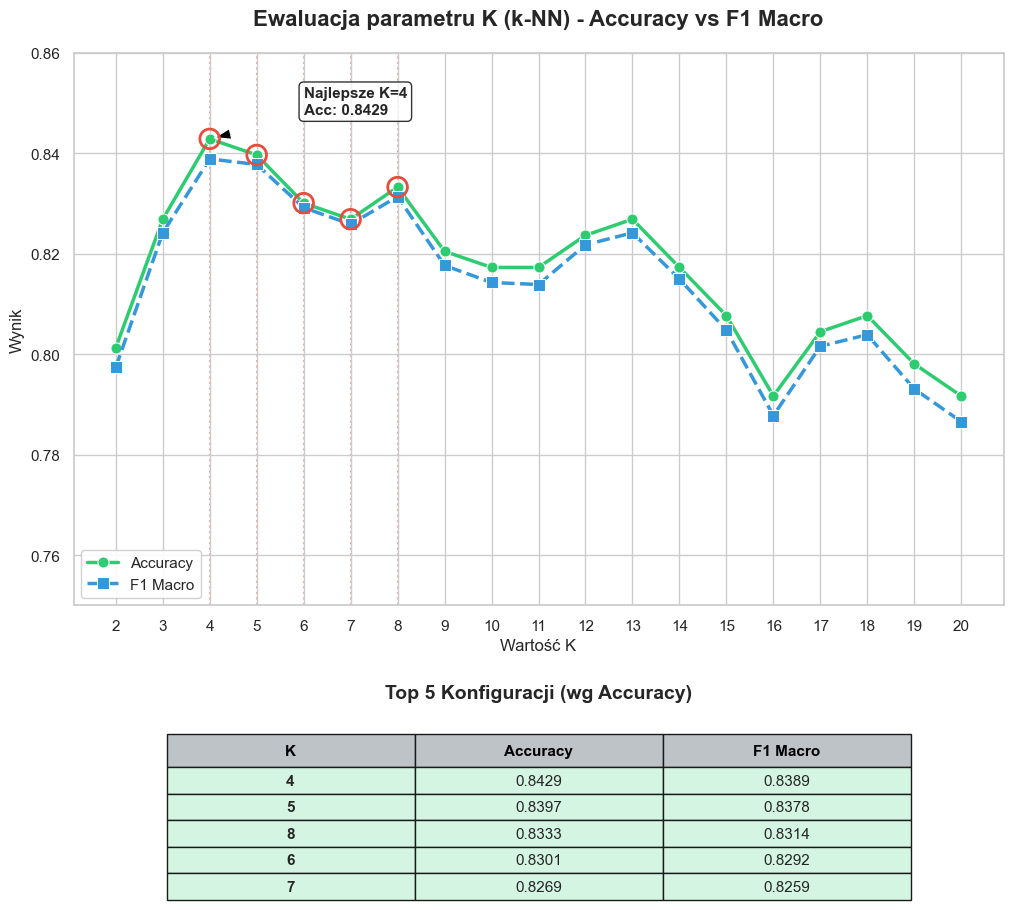

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os

# --- 1. Dane wejściowe (ZAKTUALIZOWANE) ---
data = {
    'K': list(range(2, 21)),
    'Accuracy': [
        0.8013, 0.8269, 0.8429, 0.8397, 0.8301, 
        0.8269, 0.8333, 0.8205, 0.8173, 0.8173, 
        0.8237, 0.8269, 0.8173, 0.8077, 0.7917, 
        0.8045, 0.8077, 0.7981, 0.7917
    ],
    'F1 Macro': [
        0.7974, 0.8242, 0.8389, 0.8378, 0.8292, 
        0.8259, 0.8314, 0.8177, 0.8143, 0.8139, 
        0.8218, 0.8242, 0.8150, 0.8048, 0.7878, 
        0.8016, 0.8039, 0.7931, 0.7866
    ]
}

# Tworzymy DataFrame
df = pd.DataFrame(data)

# Wyróżnione wartości K (Ensemble) - ZAKTUALIZOWANE
ensemble_k = [4, 5, 6, 7, 8]

# --- 2. Konfiguracja stylu ---
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans']

# Tworzymy figurę i osie
fig = plt.figure(figsize=(12, 11))
gs = fig.add_gridspec(2, 1, height_ratios=[3, 1], hspace=0.3)

ax_plot = fig.add_subplot(gs[0])
ax_table = fig.add_subplot(gs[1])

# --- 3. Rysowanie wykresu ---
# Linie
sns.lineplot(data=df, x='K', y='Accuracy', ax=ax_plot, marker='o', label='Accuracy', 
             color='#2ecc71', linewidth=2.5, markersize=8)
sns.lineplot(data=df, x='K', y='F1 Macro', ax=ax_plot, marker='s', label='F1 Macro', 
             color='#3498db', linewidth=2.5, markersize=8, linestyle='--')

# Podświetlenie wybranych K (Ensemble)
for k in ensemble_k:
    # Pobieramy wartość dla danego K
    row = df[df['K'] == k].iloc[0]
    ax_plot.axvline(x=k, color='#e74c3c', linestyle=':', alpha=0.5, zorder=0)
    # Dodatkowe kółko wokół punktu
    ax_plot.scatter(k, row['Accuracy'], s=200, facecolors='none', edgecolors='#e74c3c', linewidth=2, zorder=10)

# Opisy i formatowanie wykresu
ax_plot.set_title('Ewaluacja parametru K (k-NN) - Accuracy vs F1 Macro', fontsize=16, pad=20, fontweight='bold')
ax_plot.set_xlabel('Wartość K', fontsize=12)
ax_plot.set_ylabel('Wynik', fontsize=12)
ax_plot.set_xticks(range(2, 21))
# Dostosowałem zakres Y do nowych danych (min ok 0.78, max ok 0.85)
ax_plot.set_ylim(.75, 0.86) 
ax_plot.legend(loc='lower left', frameon=True, fontsize=11, framealpha=0.9)

# Dodanie adnotacji "Top Pick" - ZAKTUALIZOWANE DANE
best_k = 4
best_acc = 0.8429
ax_plot.annotate(f'Najlepsze K={best_k}\nAcc: {best_acc}', 
                 xy=(best_k, best_acc), xytext=(best_k+2, best_acc+0.005),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
                 fontsize=11, fontweight='bold',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8))

# --- 4. Rysowanie tabeli ---
ax_table.axis('off')
ax_table.set_title("Top 5 Konfiguracji (wg Accuracy)", fontsize=14, fontweight='bold', y=1.05)

# Przygotowanie danych do tabeli (Top 5)
top_5 = df.sort_values(by=['Accuracy', 'F1 Macro'], ascending=False).head(5)
top_5_values = top_5.values.tolist()
col_labels = ['K', 'Accuracy', 'F1 Macro']

# Tworzenie tabeli
the_table = ax_table.table(
    cellText=[[int(x[0]), f"{x[1]:.4f}", f"{x[2]:.4f}"] for x in top_5_values],
    colLabels=col_labels,
    loc='center',
    cellLoc='center',
    colColours=['#ecf0f1']*3,
    bbox=[0.1, 0, 0.8, 0.9]
)

the_table.auto_set_font_size(False)
the_table.set_fontsize(11)

# Stylizacja nagłówków i wierszy tabeli
for (row, col), cell in the_table.get_celld().items():
    if row == 0:
        cell.set_text_props(weight='bold', color='black')
        cell.set_facecolor('#bdc3c7')
        cell.set_height(0.15)
    elif row > 0:
        cell.set_height(0.12)
        try:
            k_cell_obj = the_table[row, 0].get_text() 
            k_val_str = k_cell_obj.get_text()
            k_val = int(float(k_val_str))
            
            if k_val in ensemble_k:
                cell.set_facecolor('#d5f5e3')
                if col == 0:
                     cell.set_text_props(weight='bold')
        except Exception:
            pass

# --- 5. Zapis i wyświetlenie ---
plt.tight_layout()
filename = 'knn_evaluation_results_updated.png'
plt.savefig(filename, dpi=300, bbox_inches='tight') 
print(f"Wykres został pomyślnie zapisany jako: {os.path.abspath(filename)}")
plt.show()